Imports

In [1]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img, img_to_array, ImageDataGenerator
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Input
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.models import Sequential
from tensorflow.keras.applications import VGG16
from tensorflow.keras.callbacks import TensorBoard
import os
import matplotlib.pyplot as plt
from PIL import Image
import time

2024-11-14 06:07:21.396512: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-11-14 06:07:21.396590: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-11-14 06:07:21.396619: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-11-14 06:07:21.404852: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-11-14 06:07:22.199849: W tensorflow/compiler/

## Setting paths

In [2]:
PATH = os.path.abspath(os.getcwd())
IMG_PATH = os.path.join(PATH, 'images')
TRAIN_PATH = os.path.join(IMG_PATH, 'train')
TEST_PATH = os.path.join(IMG_PATH, 'test')
classes = ['kangaroo', 'yak'] # 0 is kangaroo, 1 is yak
mapping =  {animal : i for i, animal in enumerate(classes)}
inverse_mapping =  {i : animal for i, animal in enumerate(classes)}

In [3]:
%rm -rf logs # Clear logs, if running again. 

## Displaying the dataset

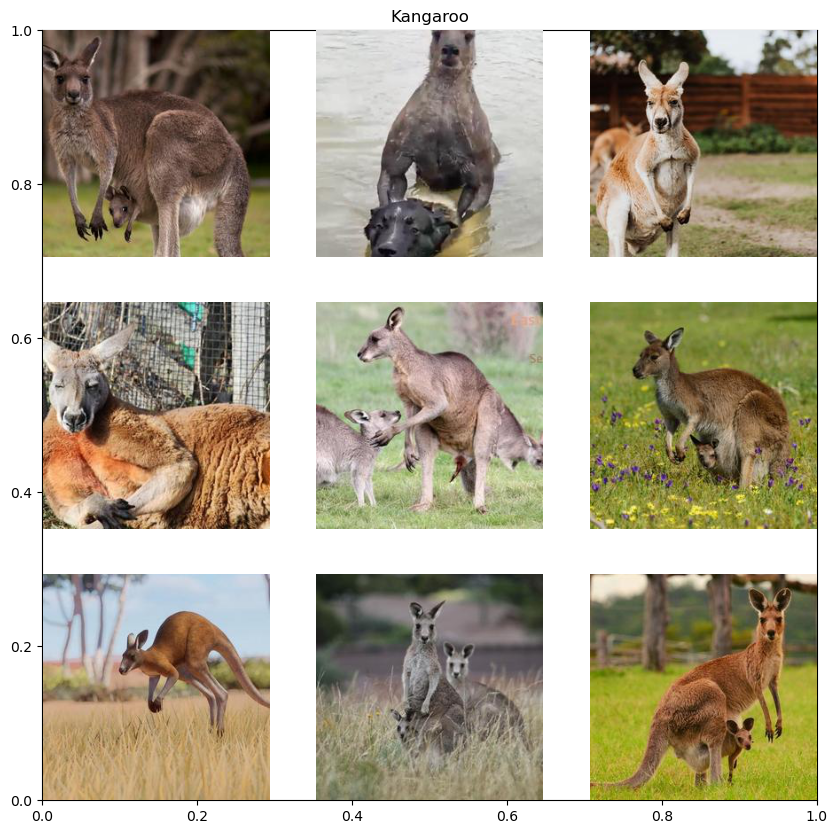

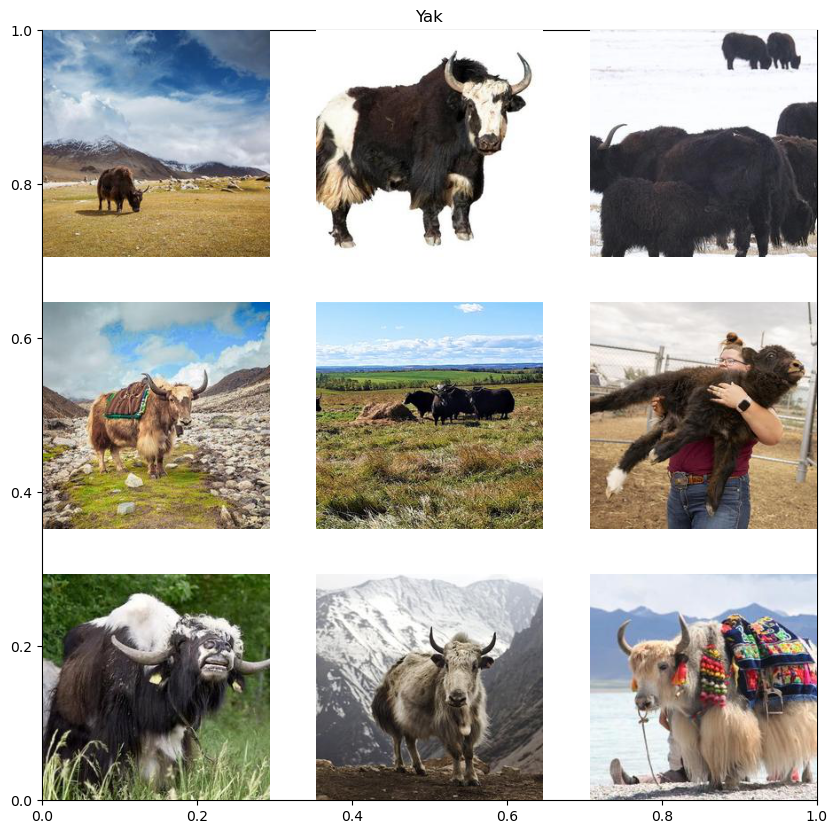

In [4]:
for animal in classes:
    folder = os.path.join(TRAIN_PATH, animal)
    plt.figure(figsize=(10, 10))
    plt.title(animal.capitalize())
    for i, filename in enumerate(os.listdir(folder)[:9]):
        img_path = os.path.join(folder, filename)
        image = Image.open(img_path)
        plt.subplot(330 + 1 + i)
        plt.imshow(image)
        plt.axis('off')

    plt.show()

## Loading the dataset to the memory

In [5]:
def load_images(folder_path):
    photos, labels = [], []
    for subdir in os.listdir(folder_path):
        subdir_path = os.path.join(folder_path, subdir)
        if os.path.isdir(subdir_path):
            for filename in os.listdir(subdir_path):
                if filename.endswith('.jpg'):
                    img_path = os.path.join(subdir_path, filename)
                    image = load_img(img_path)
                    image_array = img_to_array(image)
                    photos.append(image_array)
                    labels.append(mapping[subdir])
    return np.asarray(photos) / 255.0, np.asarray(labels)

train_photos, train_labels = load_images(TRAIN_PATH)
test_photos, test_labels = load_images(TEST_PATH)

print(f'Training images shape: {train_photos.shape}')
print(f'Training labels shape: {train_labels.shape}')
print(f'Test images shape: {test_photos.shape}')
print(f'Test labels shape: {test_labels.shape}')

Training images shape: (160, 256, 256, 3)
Training labels shape: (160,)
Test images shape: (40, 256, 256, 3)
Test labels shape: (40,)


## Tensorboard helper functions

In [6]:
import os
import time
import numpy as np
import tensorflow as tf
# to ensure reproducibility
np.random.seed(0)
tf.random.set_seed(0)

def summarize_diagnostics(history):
	plt.subplot(211)
	plt.title('Cross Entropy Loss')
	plt.plot(history.history['loss'], color='blue', label='train')
	# plt.plot(history.history['val_loss'], color='orange', label='test')

	plt.subplot(212)
	plt.title('Classification Accuracy')
	plt.plot(history.history['accuracy'], color='blue', label='train')
	# plt.plot(history.history['val_accuracy'], color='orange', label='test')

	plt.show()
# Helper function for setting up TensorBoard callback with a unique log directory
def get_tensorboard_callback(model_name):
    """
    Creates a TensorBoard callback with a unique log directory based on the model name and current timestamp.

    Args:
        model_name (str): Name of the model.

    Returns:
        tuple: TensorBoard callback and the log directory path.
    """
    timestamp = int(time.time())
    log_dir = os.path.join("./logs", "fit", model_name, str(timestamp))
    tensorboard_cb = TensorBoard(log_dir=log_dir, write_graph=False)
    return tensorboard_cb, log_dir

# Custom callback for logging training and test metrics per batch
class BatchMetricsCallback(tf.keras.callbacks.Callback):
    """
    Custom Keras callback to log training loss, training accuracy, and testing accuracy after every batch.

    Args:
        test_data (tuple): Tuple containing test images and labels.
        log_dir (str): Directory where TensorBoard logs are stored.
    """
    def __init__(self, test_data, log_dir):
        super(BatchMetricsCallback, self).__init__()
        self.test_data = test_data
        self.file_writer = tf.summary.create_file_writer(log_dir)
        self.step = 0  # Initialize step counter

    def on_train_batch_end(self, batch, logs=None):
        """
        Called at the end of each training batch.

        Args:
            batch (int): Batch index.
            logs (dict): Dictionary of logs (e.g., loss, accuracy).
        """
        self.step += 1  # Increment step per batch

        with self.file_writer.as_default():
            tf.summary.scalar('training_loss', data=logs.get('loss'), step=self.step)
            tf.summary.scalar('training_accuracy', data=logs.get('accuracy'), step=self.step)

        test_loss, test_acc = self.model.evaluate(
            self.test_data[0], self.test_data[1],
            verbose=0
        )
        with self.file_writer.as_default():
            tf.summary.scalar('test_accuracy', data=test_acc, step=self.step)

import tensorflow as tf
import numpy as np
import os

# Function to log test images grouped by predicted labels
import tensorflow as tf
import numpy as np
import os

def log_test_images(model, images, true_labels, predicted_labels, log_dir):

    images = np.stack(images, axis=0).astype(np.float32)
    
    label_map = {0: "kangaroo", 1: "yak"}
    
    # Dictionary to organize images by predicted and actual label combination
    classes = {
        "Predicted kangaroo, Actual kangaroo": [],  # Predicted 0, True 0
        "Predicted yak, Actual kangaroo": [],       # Predicted 1, True 0
        "Predicted kangaroo, Actual yak": [],       # Predicted 0, True 1
        "Predicted yak, Actual yak": []             # Predicted 1, True 1
    }
    
    for img, pred, true in zip(images, predicted_labels, true_labels):
        pred_animal = label_map.get(int(pred), "Unknown")
        true_animal = label_map.get(int(true), "Unknown")
        
        # Create tag based on predicted and actual labels
        tag = f"Predicted {pred_animal}, Actual {true_animal}"

        if tag in classes:
            classes[tag].append(img)
        else:
            print(f"Unexpected label combination: {tag}")
            pass  # Optionally handle unexpected label combinations

    # Create a TensorFlow summary writer for images
    image_log_dir = os.path.join(log_dir, 'images')
    file_writer = tf.summary.create_file_writer(image_log_dir)

    with file_writer.as_default():
        for tag, imgs in classes.items():
            if len(imgs) == 0:
                continue  # Skip logging if no images in this category

            # Convert list of images to a numpy array
            imgs_array = np.stack(imgs, axis=0)

            # Ensure images are in [0, 255] range for visualization
            if imgs_array.max() <= 1.0:
                imgs_array = imgs_array * 255.0
            imgs_array = imgs_array.astype(np.uint8)

            # Log images under the specific tag
            tf.summary.image(
                tag, 
                imgs_array, 
                step=0,  # Use a fixed step or customize it
                max_outputs=min(len(imgs_array), 100)  # Limit to 100 images per tag for performance
            )

    # Flush the writer to ensure all data is written
    file_writer.flush()


# Function to train and evaluate the model
def train_and_evaluate_model(
    model,
    train_data,
    test_data,
    model_name="model",
    epochs=20,
    batch_size=16
):

    train_photos, train_labels = train_data
    test_photos, test_labels = test_data

    tensorboard_cb, log_dir = get_tensorboard_callback(model_name)
    batch_metrics_cb = BatchMetricsCallback(
        test_data=(test_photos, test_labels),
        log_dir=log_dir
    )

    os.makedirs(log_dir, exist_ok=True)

    callbacks = [tensorboard_cb, batch_metrics_cb]
    # Compile model if not compiled already
    if not model.optimizer: 
        model.compile(
                optimizer='adam',
                loss='binary_crossentropy',
                metrics=['accuracy']
            )

    # Train model with custom callbacks for batch-level logging
    start_time = time.time()
    history = model.fit(
        train_photos, train_labels,
        epochs=epochs,
        batch_size=batch_size,
        verbose=1,
        callbacks=callbacks
    )
    end_time = time.time()

    # Final evaluation
    test_loss, test_acc = model.evaluate(test_photos, test_labels, verbose=1)
    print(f'\nFinal Test Accuracy: {test_acc * 100.0:.3f}%')
    print(f'Total Training Time: {end_time - start_time:.2f} seconds')
    # Generate predictions for test images
    predicted_labels = model.predict(test_photos, verbose=0)
    # Convert probabilities to binary class labels
    predicted_labels = (predicted_labels > 0.5).astype(int)
    # Log test images with predictions and true labels
    log_test_images(model, test_photos, test_labels, predicted_labels, log_dir)

    return history


## VGG1

2024-11-14 06:07:25.269041: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1886] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 46741 MB memory:  -> device: 0, name: NVIDIA RTX A6000, pci bus id: 0000:a1:00.0, compute capability: 8.6
2024-11-14 06:07:25.271217: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1886] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 46741 MB memory:  -> device: 1, name: NVIDIA RTX A6000, pci bus id: 0000:c1:00.0, compute capability: 8.6


Epoch 1/20


2024-11-14 06:07:26.588720: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:442] Loaded cuDNN version 8906
2024-11-14 06:07:27.372062: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7130ddc00000 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-11-14 06:07:27.372117: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA RTX A6000, Compute Capability 8.6
2024-11-14 06:07:27.372127: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (1): NVIDIA RTX A6000, Compute Capability 8.6
2024-11-14 06:07:27.452283: I ./tensorflow/compiler/jit/device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


10/10 [==============================] - 4s 125ms/step - loss: 0.6518 - accuracy: 0.7000
Epoch 2/20
10/10 [==============================] - 1s 113ms/step - loss: 0.5124 - accuracy: 0.8000
Epoch 3/20
10/10 [==============================] - 1s 110ms/step - loss: 0.6091 - accuracy: 0.6750
Epoch 4/20
10/10 [==============================] - 1s 108ms/step - loss: 0.5216 - accuracy: 0.7250
Epoch 5/20
10/10 [==============================] - 1s 108ms/step - loss: 0.4626 - accuracy: 0.7750
Epoch 6/20
10/10 [==============================] - 1s 110ms/step - loss: 0.4462 - accuracy: 0.7000
Epoch 7/20
10/10 [==============================] - 1s 106ms/step - loss: 0.4533 - accuracy: 0.7250
Epoch 8/20
10/10 [==============================] - 1s 105ms/step - loss: 0.4642 - accuracy: 0.7500
Epoch 9/20
10/10 [==============================] - 1s 111ms/step - loss: 0.5342 - accuracy: 0.7250
Epoch 10/20
10/10 [==============================] - 1s 105ms/step - loss: 0.5023 - accuracy: 0.7250
Epoch 11/2

/tmp/ipykernel_361909/672546637.py:97: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  pred_animal = label_map.get(int(pred), "Unknown")


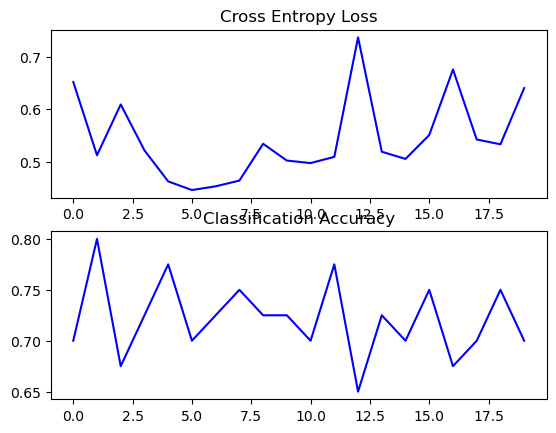

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 256, 256, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 128, 128, 32)      0         
 D)                                                              
                                                                 
 flatten (Flatten)           (None, 524288)            0         
                                                                 
 dense (Dense)               (None, 128)               67108992  
                                                                 
 dense_1 (Dense)             (None, 1)                 129       
                                                                 
Total params: 67110017 (256.00 MB)
Trainable params: 67110017 (256.00 MB)
Non-trainable params: 0 (0.00 Byte)
____________

In [7]:
def vgg1():
    model = Sequential([
        Input(shape=(256, 256, 3)),
        Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'),
        MaxPooling2D((2, 2)),
        Flatten(),
        Dense(128, activation='relu', kernel_initializer='he_uniform'),
        Dense(1, activation='sigmoid')
    ])
    opt = SGD(learning_rate=0.001, momentum=0.9)
    model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])
    return model

vgg1_model = vgg1()
train_data = (train_photos, train_labels)
test_data = (test_photos, test_labels)

# Train and evaluate
history = train_and_evaluate_model(vgg1_model, train_data, test_data, model_name="VGG 1")
summarize_diagnostics(history)
vgg1_model.summary()

## VGG3 without data augmentation

Epoch 1/20
10/10 [==============================] - 2s 118ms/step - loss: 0.5411 - accuracy: 0.6750
Epoch 2/20
10/10 [==============================] - 1s 112ms/step - loss: 0.5434 - accuracy: 0.7000
Epoch 3/20
10/10 [==============================] - 1s 132ms/step - loss: 0.8093 - accuracy: 0.6000
Epoch 4/20
10/10 [==============================] - 1s 135ms/step - loss: 0.6545 - accuracy: 0.6250
Epoch 5/20
10/10 [==============================] - 1s 120ms/step - loss: 0.4722 - accuracy: 0.7500
Epoch 6/20
10/10 [==============================] - 1s 126ms/step - loss: 0.4930 - accuracy: 0.7500
Epoch 7/20
10/10 [==============================] - 1s 120ms/step - loss: 0.5299 - accuracy: 0.7000
Epoch 8/20
10/10 [==============================] - 1s 109ms/step - loss: 0.4807 - accuracy: 0.7500
Epoch 9/20
10/10 [==============================] - 1s 119ms/step - loss: 0.6191 - accuracy: 0.6750
Epoch 10/20
10/10 [==============================] - 1s 111ms/step - loss: 0.5096 - accuracy: 0.7000

/tmp/ipykernel_361909/672546637.py:97: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  pred_animal = label_map.get(int(pred), "Unknown")


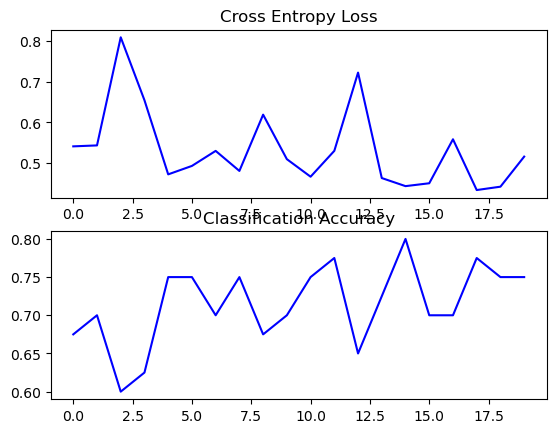

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_1 (Conv2D)           (None, 256, 256, 32)      896       
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 128, 128, 32)      0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 128, 128, 64)      18496     
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 64, 64, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_3 (Conv2D)           (None, 64, 64, 128)       73856     
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 32, 32, 128)      

In [8]:
def vgg3():
	model = Sequential()
	model.add(Input(shape=(256, 256, 3)))
	model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
	model.add(MaxPooling2D((2, 2)))
	model.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
	model.add(MaxPooling2D((2, 2)))
	model.add(Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
	model.add(MaxPooling2D((2, 2)))
	model.add(Flatten())
	model.add(Dense(128, activation='relu', kernel_initializer='he_uniform'))
	model.add(Dense(1, activation='sigmoid'))
	opt = SGD(learning_rate=0.001, momentum=0.9)
	model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])
	return model

vgg3_no_aug = vgg3()

# Train and evaluate
history = train_and_evaluate_model(vgg3_no_aug, train_data, test_data, model_name="VGG 3 (No Data Augmentation)")
summarize_diagnostics(history)
vgg3_no_aug.summary()

## VGG3 with data augmentation

#### Data Augmentation Parameters

The `ImageDataGenerator` is initialized with the following parameters:

- **`rotation_range=20`**: Randomly rotates images within a 20-degree range. This allows the model to learn rotational invariance.
- **`width_shift_range=0.1` and `height_shift_range=0.1`**: Shifts the images horizontally and vertically by up to 10% of the total width or height, simulating slight positional variations.
- **`shear_range=0.15`**: Applies a shearing transformation to the image, altering the image perspective slightly. This helps the model handle skewed perspectives.
- **`zoom_range=0.2`**: Randomly zooms in or out by up to 20%. This helps the model recognize objects at various scales.
- **`horizontal_flip=True`**: Flips the images horizontally, which is useful for images with no intrinsic left-right orientation.
- **`fill_mode='nearest'`**: Fills any missing pixels after transformations using the nearest pixel values to avoid blank areas.


In [9]:
import os
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img, array_to_img

# Augmentation settings
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.05,
    zoom_range=[0.8, 1.1],
    brightness_range=[0.8, 1.2],
    horizontal_flip=True,
    fill_mode='nearest'
)

def augment_and_save_images(src_dir, dest_dir, num_augmentations=2):
    """
    Augments images from src_dir and saves them along with originals to dest_dir.

    Parameters:
    - src_dir: Path to the original dataset directory
    - dest_dir: Path to the directory where augmented images will be saved
    - num_augmentations: Number of augmented images to create per original image
    """
    if not os.path.exists(dest_dir):
        os.makedirs(dest_dir)

    for subdir in os.listdir(src_dir):
        subdir_path = os.path.join(src_dir, subdir)
        if os.path.isdir(subdir_path):
            # Create a corresponding subdirectory in the destination directory
            dest_subdir = os.path.join(dest_dir, subdir)
            os.makedirs(dest_subdir, exist_ok=True)

            for filename in os.listdir(subdir_path):
                if filename.endswith('.jpg') or filename.endswith('.png'):
                    img_path = os.path.join(subdir_path, filename)
                    image = load_img(img_path)
                    image_array = img_to_array(image)
                    image_array = image_array.reshape((1,) + image_array.shape)

                    # Save the original image in the destination directory
                    image.save(os.path.join(dest_subdir, filename))

                    # Generate and save augmented images
                    for i, batch in enumerate(datagen.flow(image_array, batch_size=1)):
                        augmented_img = array_to_img(batch[0])
                        augmented_img.save(os.path.join(dest_subdir, f"{os.path.splitext(filename)[0]}_aug_{i}.jpg"))
                        if i >= num_augmentations - 1:
                            break

# Define paths
AUG_TRAIN_PATH = 'images/augmented_train'  # New directory for combined dataset

# Generate augmented images, saving two augmentations per original image
# augment_and_save_images(TRAIN_PATH, AUG_TRAIN_PATH, num_augmentations=2)

aug_train_photos, aug_train_labels = load_images(AUG_TRAIN_PATH)
print(f'Number of photos added: {aug_train_photos.shape[0] - train_photos.shape[0]}')
print(f'Total photos after augmentation: {aug_train_photos.shape[0]}')
print(f'Augmented Training images shape: {aug_train_photos.shape[1:]}')



Number of photos added: 320
Total photos after augmentation: 480
Augmented Training images shape: (256, 256, 3)


Epoch 1/20
10/10 [==============================] - 2s 120ms/step - loss: 0.6771 - accuracy: 0.5000
Epoch 2/20
10/10 [==============================] - 1s 107ms/step - loss: 0.6238 - accuracy: 0.7500
Epoch 3/20
10/10 [==============================] - 1s 113ms/step - loss: 0.5538 - accuracy: 0.7750
Epoch 4/20
10/10 [==============================] - 1s 110ms/step - loss: 0.5011 - accuracy: 0.7750
Epoch 5/20
10/10 [==============================] - 1s 112ms/step - loss: 0.4719 - accuracy: 0.7250
Epoch 6/20
10/10 [==============================] - 1s 118ms/step - loss: 0.4486 - accuracy: 0.7500
Epoch 7/20
10/10 [==============================] - 1s 111ms/step - loss: 0.5180 - accuracy: 0.7500
Epoch 8/20
10/10 [==============================] - 1s 110ms/step - loss: 0.4338 - accuracy: 0.7750
Epoch 9/20
10/10 [==============================] - 1s 111ms/step - loss: 0.4883 - accuracy: 0.7500
Epoch 10/20
10/10 [==============================] - 1s 109ms/step - loss: 0.4283 - accuracy: 0.7250

/tmp/ipykernel_361909/672546637.py:97: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  pred_animal = label_map.get(int(pred), "Unknown")


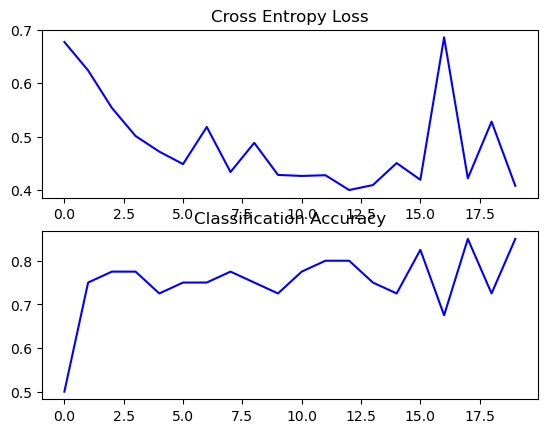

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 256, 256, 32)      896       
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 128, 128, 32)      0         
 g2D)                                                            
                                                                 
 conv2d_5 (Conv2D)           (None, 128, 128, 64)      18496     
                                                                 
 max_pooling2d_5 (MaxPoolin  (None, 64, 64, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_6 (Conv2D)           (None, 64, 64, 128)       73856     
                                                                 
 max_pooling2d_6 (MaxPoolin  (None, 32, 32, 128)      

In [10]:
aug_train_photos, aug_train_labels = load_images(AUG_TRAIN_PATH)
aug_train_data = (train_photos, train_labels)
vgg3_with_aug = vgg3()

history = train_and_evaluate_model(vgg3_with_aug, aug_train_data, test_data, model_name="VGG 3 (With Data Augmentation)")
summarize_diagnostics(history)
vgg3_with_aug.summary()

## Transfer learning using VGG16 with tuning all layers (including tuning convolution layers)


Epoch 1/20
10/10 [==============================] - 8s 237ms/step - loss: 0.6851 - accuracy: 0.5750
Epoch 2/20
10/10 [==============================] - 2s 232ms/step - loss: 0.6045 - accuracy: 0.8750
Epoch 3/20
10/10 [==============================] - 2s 230ms/step - loss: 0.5309 - accuracy: 0.9000
Epoch 4/20
10/10 [==============================] - 2s 231ms/step - loss: 0.4621 - accuracy: 0.9000
Epoch 5/20
10/10 [==============================] - 2s 230ms/step - loss: 0.4030 - accuracy: 0.9000
Epoch 6/20
10/10 [==============================] - 2s 237ms/step - loss: 0.3518 - accuracy: 0.9250
Epoch 7/20
10/10 [==============================] - 2s 231ms/step - loss: 0.3096 - accuracy: 0.9250
Epoch 8/20
10/10 [==============================] - 2s 231ms/step - loss: 0.2700 - accuracy: 0.9500
Epoch 9/20
10/10 [==============================] - 2s 231ms/step - loss: 0.2403 - accuracy: 0.9500
Epoch 10/20
10/10 [==============================] - 2s 235ms/step - loss: 0.2196 - accuracy: 0.9250

/tmp/ipykernel_361909/672546637.py:97: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  pred_animal = label_map.get(int(pred), "Unknown")


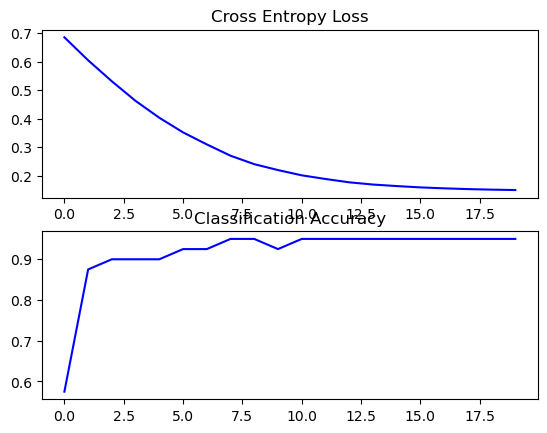

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 8, 8, 512)         14714688  
                                                                 
 flatten_3 (Flatten)         (None, 32768)             0         
                                                                 
 dense_6 (Dense)             (None, 4096)              134221824 
                                                                 
 dense_7 (Dense)             (None, 4096)              16781312  
                                                                 
 dense_8 (Dense)             (None, 1)                 4097      
                                                                 
Total params: 165721921 (632.18 MB)
Trainable params: 165721921 (632.18 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [11]:

vgg16 = VGG16(weights='imagenet', include_top=False, input_shape=(256, 256, 3))

for layer in vgg16.layers:
    layer.trainable = True

vgg16_all_layers_tuned = Sequential()
vgg16_all_layers_tuned.add(vgg16)
vgg16_all_layers_tuned.add(Flatten())
vgg16_all_layers_tuned.add(Dense(4096, activation='relu'))
vgg16_all_layers_tuned.add(Dense(4096, activation='relu'))
vgg16_all_layers_tuned.add(Dense(1, activation='sigmoid'))
opt = SGD(learning_rate=1e-4, momentum=0.9)
vgg16_all_layers_tuned.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])

history = train_and_evaluate_model(vgg16_all_layers_tuned, train_data, test_data, model_name="VGG 16 (All Layers Tuned)")
summarize_diagnostics(history)
vgg16_all_layers_tuned.summary()

## Transfer learning using VGG16 with tuning only final MLP layers (excluding convolution layers)

Epoch 1/20
10/10 [==============================] - 3s 242ms/step - loss: 0.6855 - accuracy: 0.4750
Epoch 2/20
10/10 [==============================] - 2s 214ms/step - loss: 0.6014 - accuracy: 0.7750
Epoch 3/20
10/10 [==============================] - 2s 201ms/step - loss: 0.5398 - accuracy: 0.8750
Epoch 4/20
10/10 [==============================] - 2s 201ms/step - loss: 0.4899 - accuracy: 0.8500
Epoch 5/20
10/10 [==============================] - 2s 204ms/step - loss: 0.4533 - accuracy: 0.9250
Epoch 6/20
10/10 [==============================] - 2s 199ms/step - loss: 0.4234 - accuracy: 0.9250
Epoch 7/20
10/10 [==============================] - 2s 204ms/step - loss: 0.3993 - accuracy: 0.9500
Epoch 8/20
10/10 [==============================] - 2s 207ms/step - loss: 0.3763 - accuracy: 0.9250
Epoch 9/20
10/10 [==============================] - 2s 202ms/step - loss: 0.3579 - accuracy: 0.9500
Epoch 10/20
10/10 [==============================] - 2s 201ms/step - loss: 0.3424 - accuracy: 0.9500

/tmp/ipykernel_361909/672546637.py:97: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  pred_animal = label_map.get(int(pred), "Unknown")


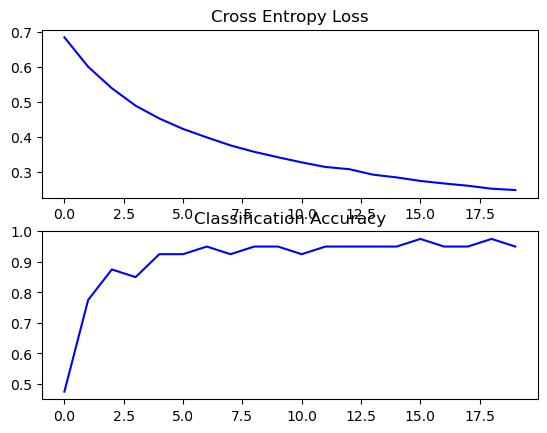

Model: "sequential_27"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 8, 8, 512)         14714688  
                                                                 
 flatten_28 (Flatten)        (None, 32768)             0         
                                                                 
 dense_134 (Dense)           (None, 4096)              134221824 
                                                                 
 dense_135 (Dense)           (None, 4096)              16781312  
                                                                 
 dense_136 (Dense)           (None, 1)                 4097      
                                                                 
Total params: 165721921 (632.18 MB)
Trainable params: 151007233 (576.05 MB)
Non-trainable params: 14714688 (56.13 MB)
_________________________________________________________________


In [39]:
vgg16 = VGG16(weights='imagenet', include_top=False, input_shape=(256, 256, 3))

for layer in vgg16.layers:
    layer.trainable = False

vgg16_mlp_layer_tuned = Sequential()
vgg16_mlp_layer_tuned.add(vgg16)
vgg16_mlp_layer_tuned.add(Flatten())
vgg16_mlp_layer_tuned.add(Dense(4096, activation='relu'))
vgg16_mlp_layer_tuned.add(Dense(4096, activation='relu'))
vgg16_mlp_layer_tuned.add(Dense(1, activation='sigmoid'))
opt = SGD(learning_rate=1e-4, momentum=0.9)
vgg16_mlp_layer_tuned.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])


history = train_and_evaluate_model(vgg16_mlp_layer_tuned, train_data, test_data, model_name="VGG 16 (MLP Layer Tuned)")
summarize_diagnostics(history)
vgg16_mlp_layer_tuned.summary()

Total parameters in VGG16: 165721921
Epoch 1/20
10/10 [==============================] - 5s 121ms/step - loss: 20.3348 - accuracy: 0.5000
Epoch 2/20
10/10 [==============================] - 1s 122ms/step - loss: 25.5518 - accuracy: 0.5000
Epoch 3/20
10/10 [==============================] - 1s 122ms/step - loss: 15.1424 - accuracy: 0.5000
Epoch 4/20
10/10 [==============================] - 1s 115ms/step - loss: 6.2451 - accuracy: 0.5000
Epoch 5/20
10/10 [==============================] - 1s 128ms/step - loss: 1.1713 - accuracy: 0.5000
Epoch 6/20
10/10 [==============================] - 1s 118ms/step - loss: 0.8917 - accuracy: 0.5000
Epoch 7/20
10/10 [==============================] - 1s 129ms/step - loss: 0.8768 - accuracy: 0.5000
Epoch 8/20
10/10 [==============================] - 1s 122ms/step - loss: 0.6439 - accuracy: 0.6500
Epoch 9/20
10/10 [==============================] - 1s 119ms/step - loss: 0.4757 - accuracy: 0.7000
Epoch 10/20
10/10 [==============================] - 1s 139m

/tmp/ipykernel_361909/672546637.py:97: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  pred_animal = label_map.get(int(pred), "Unknown")


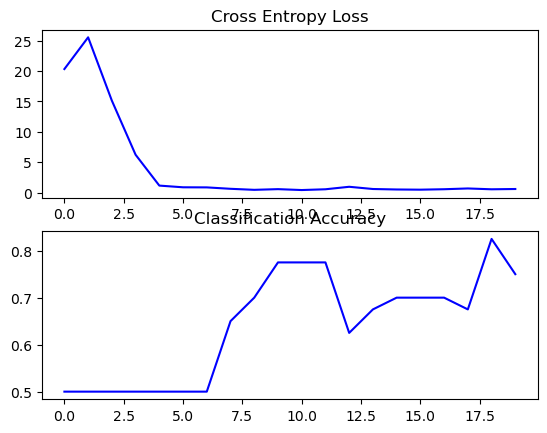

Model: "sequential_55"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_56 (Flatten)        (None, 196608)            0         
                                                                 
 dense_411 (Dense)           (None, 828)               162792252 
                                                                 
 dense_412 (Dense)           (None, 512)               424448    
                                                                 
 dense_413 (Dense)           (None, 512)               262656    
                                                                 
 dense_414 (Dense)           (None, 512)               262656    
                                                                 
 dense_415 (Dense)           (None, 512)               262656    
                                                                 
 dense_416 (Dense)           (None, 512)             

In [67]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten

# Load the VGG16 model to get the parameter count
print(f"Total parameters in VGG16: {vgg16_mlp_layer_tuned.count_params()}")

# Create an MLP model with comparable parameters
def mlp():
    model = Sequential()
    model.add(Input(shape=(256, 256, 3)))  # Change input shape to match data
    model.add(Flatten())
    model.add(Dense(828, activation='relu', kernel_initializer='he_uniform'))
    model.add(Dense(512, activation='relu', kernel_initializer='he_uniform'))
    model.add(Dense(512, activation='relu', kernel_initializer='he_uniform'))
    model.add(Dense(512, activation='relu', kernel_initializer='he_uniform'))
    model.add(Dense(512, activation='relu', kernel_initializer='he_uniform'))
    model.add(Dense(512, activation='relu', kernel_initializer='he_uniform'))
    model.add(Dense(512, activation='relu', kernel_initializer='he_uniform'))
    model.add(Dense(512, activation='relu', kernel_initializer='he_uniform'))
    model.add(Dense(512, activation='relu', kernel_initializer='he_uniform'))
    model.add(Dense(256, activation='relu', kernel_initializer='he_uniform'))
    model.add(Dense(256, activation='relu', kernel_initializer='he_uniform'))
    model.add(Dense(256, activation='relu', kernel_initializer='he_uniform'))
    model.add(Dense(128, activation='relu', kernel_initializer='he_uniform'))
    model.add(Dense(128, activation='relu', kernel_initializer='he_uniform'))
    model.add(Dense(128, activation='relu', kernel_initializer='he_uniform'))
    model.add(Dense(1, activation='sigmoid'))
    return model

mlp_model = mlp()
history = train_and_evaluate_model(mlp_model, train_data, test_data, model_name="MLP Model")
summarize_diagnostics(history)
mlp_model.summary()

## Comparing the MLP and VGG models

As we can see, the MLP model has a similar number of parameters as the VGG 16 model (around 165 million), in addition to 16 dense layers in place of convolutional layers. However, the VGG 16 model has a much higher accuracy of 95% than the MLP model (75%). The accuracy, however, is comparable to the VGG 3 model without data augmentation (75%), however the VGG3 model achieves this accuracy with much lesser parameters (less than 17 million).

This can be attributed to the fact that convolutional layers are better suited for image classification tasks, as they can capture spatial hierarchies and patterns in the images. Moreover, in this particular case the VGG 16 model benefits from transfer learning from the ImageNet dataset, which allows it to leverage pre-trained weights to achieve better performance.
